## Author: Sruti Keerti Munukutla

In [1]:
# import libraries
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
#define the network used for training MNSIT digits again to load model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [3]:
network = Net()

#load model
network.load_state_dict(torch.load('./results/model.pth'))
print(network)

# freezes the parameters for the whole network
for param in network.parameters():
    param.requires_grad = False

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [4]:
#replacing last layer for alpha, beta, gamma
network.fc2 = nn.Linear(50, 3)
print(network)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=3, bias=True)
)


In [5]:
#reference path to greek letter images
training_set_path = './greek_train'

In [6]:
# greek data set transform
class GreekTransform:
    def __init__(self):
        pass

    def __call__(self, x):
        x = torchvision.transforms.functional.rgb_to_grayscale( x )
        x = torchvision.transforms.functional.affine( x, 0, (0,0), 36/128, 0 )
        x = torchvision.transforms.functional.center_crop( x, (28, 28) )
        return torchvision.transforms.functional.invert( x )

In [7]:
# load images
greek_train = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder( training_set_path,
                                          transform = torchvision.transforms.Compose( [torchvision.transforms.ToTensor(),
                                                                                       GreekTransform(),
                                                                                       torchvision.transforms.Normalize(
                                                                                           (0.1307,), (0.3081,) ) ] ) ),
        batch_size = 5,
        shuffle = True )

In [8]:
print(greek_train)

In [9]:
examples_greek = enumerate(greek_train)
batch_idx, (example_data_greek, example_targets_greek) = next(examples_greek)

example_data_greek.shape

torch.Size([5, 1, 28, 28])

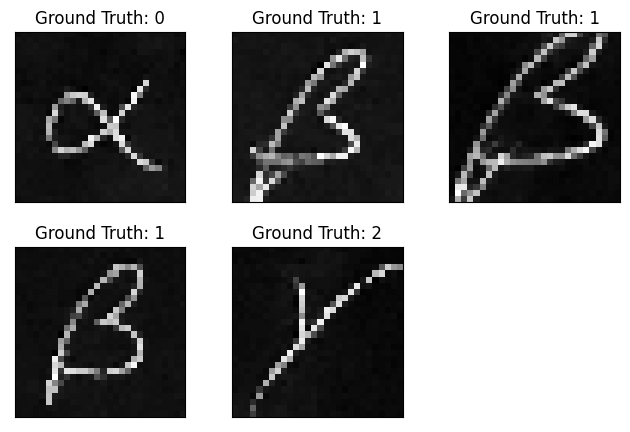

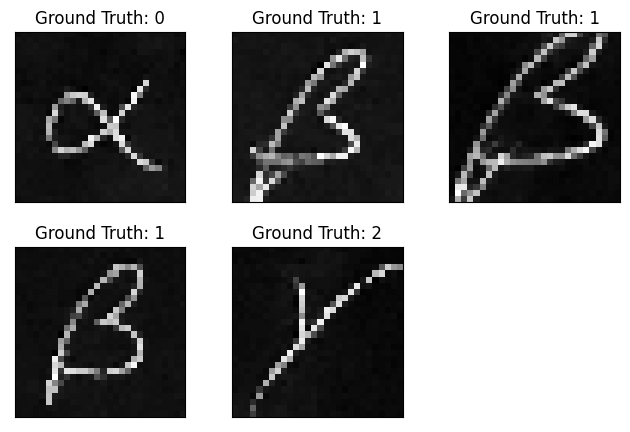

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(5):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data_greek[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets_greek[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [11]:
#use model to learn for greek letter data
n_epochs = 170
batch_size_train = 5
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 3

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)


In [12]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(greek_train.dataset) for i in range(n_epochs + 1)]

In [13]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(greek_train):
    
        #forward pass
        output = network(data)
        loss = F.nll_loss(output, target)

        #backward propagartion
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(greek_train.dataset),
            100. * batch_idx / len(greek_train), loss.item()))
          train_losses.append(loss.item())
          train_counter.append(
            (batch_idx*batch_size_train) + ((epoch-1)*len(greek_train.dataset)))

In [14]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in greek_train:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(greek_train.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(greek_train.dataset),
    100. * correct / len(greek_train.dataset)))

In [15]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/var/folders/7t/ngfzpdfd4q39hxvplh70gj380000gn/T/ipykernel_82694/4047452366.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/usr/local/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1426, Accuracy: 10/27 (37%)

Train Epoch: 1 [0/27 (0%)]	Loss: 1.168989
Train Epoch: 1 [15/27 (50%)]	Loss: 1.533049

Test set: Avg. loss: 1.0550, Accuracy: 13/27 (48%)

Train Epoch: 2 [0/27 (0%)]	Loss: 1.264481
Train Epoch: 2 [15/27 (50%)]	Loss: 1.045900

Test set: Avg. loss: 0.9709, Accuracy: 16/27 (59%)

Train Epoch: 3 [0/27 (0%)]	Loss: 0.981451
Train Epoch: 3 [15/27 (50%)]	Loss: 0.849237

Test set: Avg. loss: 0.9106, Accuracy: 20/27 (74%)

Train Epoch: 4 [0/27 (0%)]	Loss: 0.688962
Train Epoch: 4 [15/27 (50%)]	Loss: 1.060296

Test set: Avg. loss: 0.8547, Accuracy: 22/27 (81%)

Train Epoch: 5 [0/27 (0%)]	Loss: 0.876885
Train Epoch: 5 [15/27 (50%)]	Loss: 0.857493

Test set: Avg. loss: 0.8026, Accuracy: 25/27 (93%)

Train Epoch: 6 [0/27 (0%)]	Loss: 0.579143
Train Epoch: 6 [15/27 (50%)]	Loss: 0.622685

Test set: Avg. loss: 0.7593, Accuracy: 24/27 (89%)

Train Epoch: 7 [0/27 (0%)]	Loss: 0.772649
Train Epoch: 7 [15/27 (50%)]	Loss: 0.570675

Test set: Avg. loss: 0.723

Train Epoch: 61 [15/27 (50%)]	Loss: 0.527185

Test set: Avg. loss: 0.2438, Accuracy: 26/27 (96%)

Train Epoch: 62 [0/27 (0%)]	Loss: 0.372263
Train Epoch: 62 [15/27 (50%)]	Loss: 0.518570

Test set: Avg. loss: 0.2413, Accuracy: 26/27 (96%)

Train Epoch: 63 [0/27 (0%)]	Loss: 0.267618
Train Epoch: 63 [15/27 (50%)]	Loss: 0.337092

Test set: Avg. loss: 0.2394, Accuracy: 26/27 (96%)

Train Epoch: 64 [0/27 (0%)]	Loss: 0.493423
Train Epoch: 64 [15/27 (50%)]	Loss: 0.248591

Test set: Avg. loss: 0.2370, Accuracy: 26/27 (96%)

Train Epoch: 65 [0/27 (0%)]	Loss: 0.493720
Train Epoch: 65 [15/27 (50%)]	Loss: 0.360104

Test set: Avg. loss: 0.2343, Accuracy: 26/27 (96%)

Train Epoch: 66 [0/27 (0%)]	Loss: 0.834030
Train Epoch: 66 [15/27 (50%)]	Loss: 0.587953

Test set: Avg. loss: 0.2323, Accuracy: 26/27 (96%)

Train Epoch: 67 [0/27 (0%)]	Loss: 0.404834
Train Epoch: 67 [15/27 (50%)]	Loss: 0.227749

Test set: Avg. loss: 0.2292, Accuracy: 26/27 (96%)

Train Epoch: 68 [0/27 (0%)]	Loss: 0.355644
Train Epoch: 


Test set: Avg. loss: 0.1605, Accuracy: 26/27 (96%)

Train Epoch: 121 [0/27 (0%)]	Loss: 0.572193
Train Epoch: 121 [15/27 (50%)]	Loss: 0.165802

Test set: Avg. loss: 0.1595, Accuracy: 26/27 (96%)

Train Epoch: 122 [0/27 (0%)]	Loss: 0.441149
Train Epoch: 122 [15/27 (50%)]	Loss: 0.262214

Test set: Avg. loss: 0.1586, Accuracy: 26/27 (96%)

Train Epoch: 123 [0/27 (0%)]	Loss: 0.231670
Train Epoch: 123 [15/27 (50%)]	Loss: 0.734879

Test set: Avg. loss: 0.1585, Accuracy: 26/27 (96%)

Train Epoch: 124 [0/27 (0%)]	Loss: 0.586948
Train Epoch: 124 [15/27 (50%)]	Loss: 0.378067

Test set: Avg. loss: 0.1578, Accuracy: 26/27 (96%)

Train Epoch: 125 [0/27 (0%)]	Loss: 0.520788
Train Epoch: 125 [15/27 (50%)]	Loss: 0.439107

Test set: Avg. loss: 0.1567, Accuracy: 26/27 (96%)

Train Epoch: 126 [0/27 (0%)]	Loss: 0.068770
Train Epoch: 126 [15/27 (50%)]	Loss: 0.267848

Test set: Avg. loss: 0.1560, Accuracy: 26/27 (96%)

Train Epoch: 127 [0/27 (0%)]	Loss: 0.453928
Train Epoch: 127 [15/27 (50%)]	Loss: 0.800095

In [16]:
with torch.no_grad():
    output = network(example_data_greek)

/var/folders/7t/ngfzpdfd4q39hxvplh70gj380000gn/T/ipykernel_82694/4047452366.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


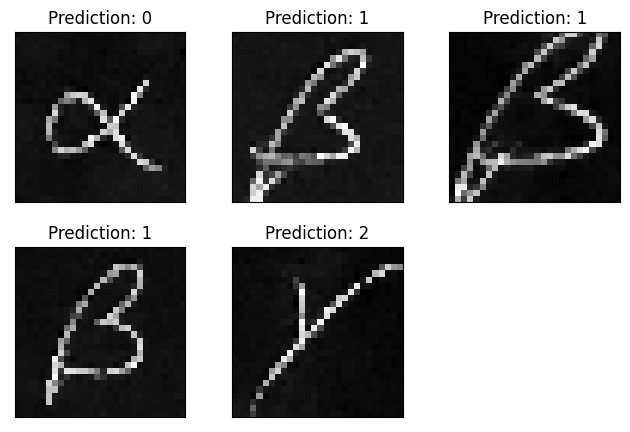

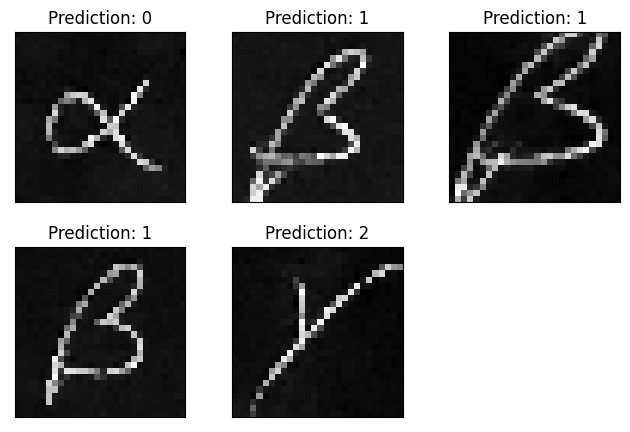

In [17]:
fig = plt.figure()
for i in range(5):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data_greek[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

Text(0, 0.5, 'negative log likelihood loss')

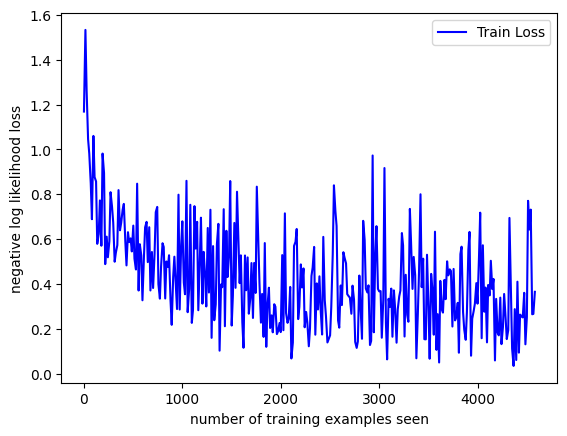

In [18]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
